In [209]:
import pandas as pd
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 0.) Clean the Apple Data to get a quarterly series of EPS.

In [44]:
data = pd.read_csv('AAPL_quarterly_financials.csv', index_col=0, header=None).T
y = data.reindex(index=data.index[::-1])
y.set_index('name', inplace=True)
y.drop(y.tail(1).index,inplace=True)
y.index = pd.to_datetime(y.index)
Y = y['BasicEPS']
Y = Y.fillna(0.)
Y

name
1985-09-30      0.0
1985-12-31    0.004
1986-03-31    0.002
1986-06-30    0.002
1986-09-30      0.0
              ...  
2022-09-30     1.29
2022-12-31     1.89
2023-03-31     1.53
2023-06-30     1.27
2023-09-30     1.47
Name: BasicEPS, Length: 153, dtype: object

# 1.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data. Clean it to have a quarterly average.

In [176]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["Credit card","Debt","Job","Extra income","Cellphone","Apple Store","Ucla","Hospital","Tickets","Bank"]  # Add your keywords here
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [177]:
dfq = df.resample('Q').mean()
dfq = dfq[dfq.index <= '2023-09-30']
dfq

,Credit card,Debt,Job,Extra income,Cellphone,Apple Store,Ucla,Hospital,Tickets,Bank
date,,,,,,,,,,
2004-03-31,51.000000,62.000000,71.666667,70.666667,86.333333,6.333333,87.000000,79.333333,88.666667,63.666667
2004-06-30,47.000000,57.000000,69.666667,68.333333,82.666667,6.333333,83.000000,76.000000,90.666667,65.000000
2004-09-30,52.333333,56.000000,68.000000,86.666667,90.333333,8.333333,74.333333,78.666667,91.666667,67.666667
2004-12-31,50.000000,60.333333,60.000000,61.333333,89.333333,10.333333,87.000000,74.333333,90.333333,65.333333
2005-03-31,46.666667,59.000000,67.333333,77.666667,92.666667,11.000000,81.666667,79.333333,97.666667,66.333333
...,...,...,...,...,...,...,...,...,...,...
2022-09-30,93.333333,50.333333,51.333333,79.333333,30.666667,24.666667,33.000000,89.000000,70.666667,82.333333
2022-12-31,85.333333,48.333333,44.000000,76.666667,29.333333,24.666667,41.000000,75.000000,67.333333,73.000000
2023-03-31,86.666667,54.333333,47.333333,77.333333,30.333333,19.000000,41.333333,82.666667,65.333333,80.000000


# 2.) Normalize all the X data

In [178]:
from sklearn.preprocessing import StandardScaler

In [179]:
scaler = StandardScaler()

In [180]:
X_scaled = scaler.fit_transform(dfq)

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [181]:
from sklearn.linear_model import Lasso

In [212]:
Y_04 = Y[Y.index >= '2004-03-31']

In [213]:
lasso = Lasso(alpha = 0.2)

In [214]:
lasso.fit(X_scaled,Y_04)

Lasso(alpha=0.2)

In [215]:
coefficients = lasso.coef_

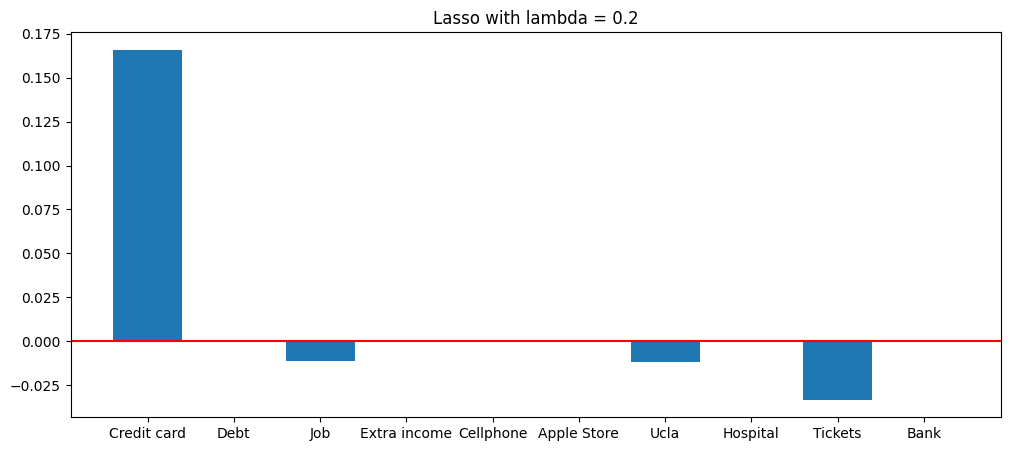

In [216]:
names = ['Credit card', 'Debt', 'Job', 'Extra income', 'Cellphone',
       'Apple Store', 'Ucla', 'Hospital', 'Tickets', 'Bank']

plt.figure(figsize=(12,5))
plt.title('Lasso with lambda = 0.2')
plt.bar(range(len(coefficients)), coefficients, tick_label=names)
plt.axhline(0, color = 'red')
plt.show()

# 5.) Do these coefficient magnitudes make sense?

The direction of the coefficients do not always make sense. Credit card appears to impact positively to apple revenues probably because when the economic situation is well, people are more willing to acquire more debt. Job searches have a negative coefficient because people are in a worse situation and probably looking for new job opportunities. However, Ucla and tickets have no immediate intuition.

# 6.) Run a for loop looking at 10 different Lambdas and plot the coefficient magnitude for each.

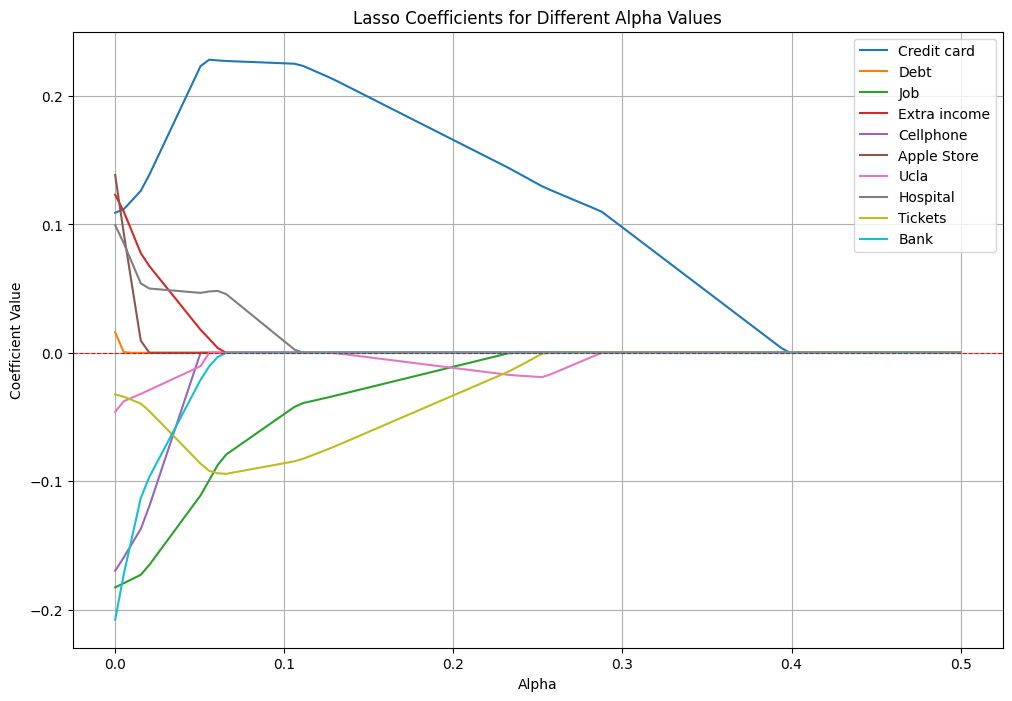

In [228]:
alphas = np.linspace(0, 0.5, 100)

# List to store coefficients for each alpha
coefficients_list = []

# Loop through different alpha values
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_scaled, Y_04)
    coefficients = lasso.coef_
    coefficients_list.append(coefficients)

# Transpose the coefficients list for easier plotting
coefficients_array = np.array(coefficients_list).T

# Plotting
plt.figure(figsize=(12, 8))
for i in range(len(names)):
    plt.plot(alphas, coefficients_array[i], label=names[i])

plt.xlabel('Alpha')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients for Different Alpha Values')
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.legend()
plt.grid(True)
plt.show()

# 7.) Run a cross validation. What is your ideal lambda?

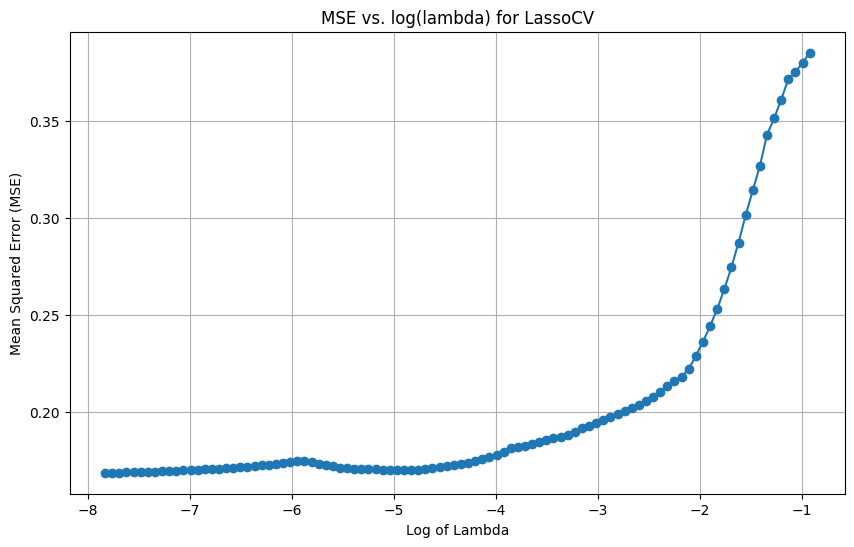

In [226]:
from sklearn.linear_model import LassoCV
modCV = LassoCV().fit(X_scaled,Y_04)

alphas = modCV.alphas_
mse_values = modCV.mse_path_.mean(axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(np.log(alphas), mse_values, marker='o')
plt.xlabel('Log of Lambda')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. log(lambda) for LassoCV')
plt.grid(True)
plt.show()

In [225]:
# Minimum lambda
a=modCV.alpha_
a

0.000397672271760685

Seems that the optimal lambda is very close to zero: 0.0003976